<a href="https://colab.research.google.com/github/omermosa/Image-Compression-With-AutoEncoders-using-TF/blob/main/Image_compression_using_DC_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
keras=tf.keras
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
x_test2=x_test.astype(np.float32)/255
x_train2=x_train.astype(np.float32)/255

In [2]:
x_train=np.load('/content/drive/My Drive/PMDL/A2/X_train_128.npy')
y_train=np.load('/content/drive/My Drive/PMDL/A2/y_train_128.npy')
x_test=np.load('/content/drive/My Drive/PMDL/A2/X_test_128.npy')
y_test=np.load('/content/drive/My Drive/PMDL/A2/y_test_128.npy')

In [3]:
x_train=x_train.reshape(-1,128,128,3)
x_test=x_train.reshape(-1,128,128,3)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)


In [4]:
In=keras.layers.Input(shape=x_train.shape[1:])

In [56]:
def encoder(In): # encoder model
  X=keras.layers.Conv2D(96,5,activation='relu',padding='same')(In)
  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.Conv2D(96,5,activation='relu',padding='same')(X)
  X=keras.layers.BatchNormalization()(X)
  X=keras.layers.Conv2D(96,5,activation='relu',padding='same')(X)
  X=keras.layers.BatchNormalization()(X)
  

  #X=keras.layers.MaxPool2D((2,2),padding='same')(X)

  X=keras.layers.Conv2D(96,5,activation='relu',padding='same')(X)
  X=keras.layers.BatchNormalization()(X)
  X=keras.layers.MaxPool2D((2,2),padding='same')(X)
  X=keras.layers.Conv2D(96,5,padding='same')(X)
  X=keras.layers.BatchNormalization()(X)
  X=keras.layers.Conv2D(32,5,padding='same')(X)
  X=keras.layers.BatchNormalization()(X)
  

  X=keras.layers.Conv2D(3,5,padding='same')(X)


  enc_model=keras.Model(In,X)
  return enc_model


In [57]:
def decoder(dc_input): #decoder model
  X=keras.layers.Conv2D(96,5,padding='same')(dc_input)

  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.Conv2D(96,5,padding='same')(X)
  #X=keras.layers.UpSampling2D((2,2))(X)
  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.Conv2D(96,5,padding='same',activation='relu')(X)
  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.UpSampling2D((2,2))(X)
  X=keras.layers.Conv2D(96,5,padding='same',activation='relu')(X)
  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.Conv2D(96,5,padding='same',activation='relu')(X)
  X=keras.layers.BatchNormalization()(X) 

  X=keras.layers.Conv2D(48,5,padding='same',activation='relu')(X)
  X=keras.layers.BatchNormalization()(X) 


  X=keras.layers.Conv2D(16,5,padding='same',activation='relu')(X)
  
  X=keras.layers.BatchNormalization()(X) 

  

  X=keras.layers.Conv2D(3,5,padding='same',activation='sigmoid')(X)
  dec=keras.Model(dc_input,X)
  return dec

In [58]:
enc=encoder(In)
enc_out=enc(In)


In [59]:
dc_input=keras.layers.Input(enc_out.shape[1:])
dec=decoder(dc_input)

In [60]:
dc_out=dec(enc_out)

In [61]:
model=keras.Model(inputs=In,outputs=dc_out) #model connecting both

In [81]:
enc.summary() #encoder summary

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 128, 96)      7296      
_________________________________________________________________
batch_normalization_52 (Batc (None, 128, 128, 96)      384       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 96)      230496    
_________________________________________________________________
batch_normalization_53 (Batc (None, 128, 128, 96)      384       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 128, 128, 96)      230496    
_________________________________________________________________
batch_normalization_54 (Batc (None, 128, 128, 96)    

In [82]:
dec.summary() #decoder summary.

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 64, 64, 96)        7296      
_________________________________________________________________
batch_normalization_58 (Batc (None, 64, 64, 96)        384       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 64, 64, 96)        230496    
_________________________________________________________________
batch_normalization_59 (Batc (None, 64, 64, 96)        384       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 64, 64, 96)        230496    
_________________________________________________________________
batch_normalization_60 (Batc (None, 64, 64, 96)      

In [62]:
model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
functional_31 (Functional)   (None, 64, 64, 3)         1010563   
_________________________________________________________________
functional_33 (Functional)   (None, 128, 128, 3)       1067123   
Total params: 2,077,686
Trainable params: 2,075,574
Non-trainable params: 2,112
_________________________________________________________________


In [63]:
es=keras.callbacks.EarlyStopping(patience=6)
ckp=keras.callbacks.ModelCheckpoint('ckpt_encdec.h5',save_best_only=True,save_weights_only=False,monitor='val_loss') #chekpoint

In [64]:
model.compile(optimizer=keras.optimizers.Adam(),loss='mse')

In [75]:
model.fit(x=x_train,y=x_train,batch_size=32,epochs=10,callbacks=[es,ckp],validation_data=(x_test,x_test))

Epoch 1/10
100/100 [==============================] - 26s 256ms/step - loss: 0.0035 - val_loss: 0.0111
Epoch 2/10
100/100 [==============================] - 23s 235ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 3/10
100/100 [==============================] - 23s 235ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 4/10
100/100 [==============================] - 24s 235ms/step - loss: 0.0034 - val_loss: 0.0091
Epoch 5/10
100/100 [==============================] - 23s 235ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 6/10
100/100 [==============================] - 24s 237ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 7/10
100/100 [==============================] - 24s 235ms/step - loss: 0.0031 - val_loss: 0.0054
Epoch 8/10
100/100 [==============================] - 24s 235ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 9/10
100/100 [==============================] - 24s 235ms/step - loss: 0.0027 - val_loss: 0.0099
Epoch 10/10
100/100 [==============================] - 24s 235ms/step - l

In [71]:
keras.backend.clear_session()

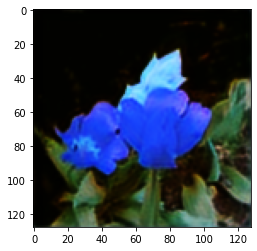

In [79]:
c=model.predict(x_test[10].reshape(1,128,128,3))
plt.imshow(c.reshape(128,128,3),vmin=0,vmax=1)

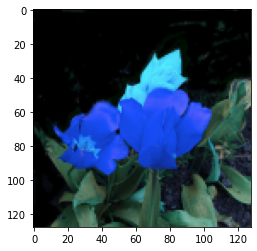

In [80]:
plt.imshow(x_test[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


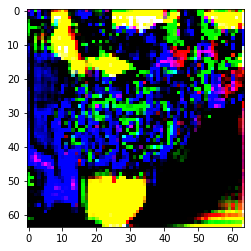

In [49]:
X_comp=np.array(enc(x_test[0].reshape(-1,128,128,3)))

plt.imshow(X_comp.reshape(64,64,3),vmin=0,vmax=1)

In [112]:
# read the imgae
import cv2 
img=cv2.imread('/content/sample_data/img.jpg')

In [118]:
img=np.array(img).astype(np.float32)

In [120]:
img/=255 #normalize

In [ ]:
#predict it.

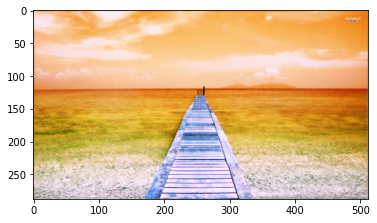

In [121]:
c=model.predict(img.reshape((1,)+img.shape))
plt.imshow(c.reshape(img.shape),vmin=0,vmax=1)

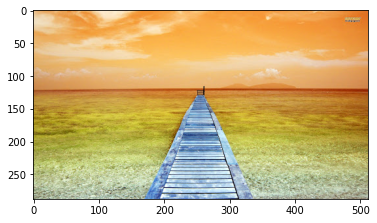

In [109]:
plt.imshow(img) #show original.

In [ ]:
#Encoding the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 144, 256, 3)


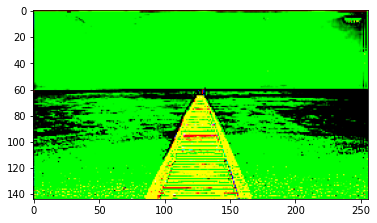

In [169]:
X_comp=np.array(enc(img.reshape((1,)+img.shape)))
print(X_comp.shape)
plt.imshow(X_comp.reshape(X_comp.shape[1:]),vmin=0,vmax=1);

In [170]:
#save the encoding
np.save('comp.npy',X_comp.astype(np.float32))

In [ ]:
#load the encoded image and decode it

In [171]:
x=np.load('comp.npy')

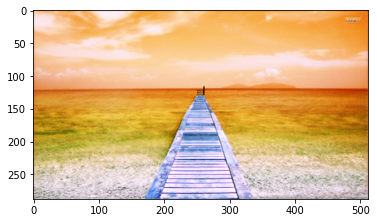

In [172]:
x=np.array(dec(x))
plt.imshow(x.reshape(x.shape[1:]),vmin=0,vmax=1);

In [ ]:
_input_layer = keras.layers.Input(shape=(32, 32, 3))
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
encoded_layer1 = Conv2D(512, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer1 = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer1 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu',padding='same')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
decoded_layer3 = Conv2D(128, (3, 3), activation='relu',padding='same')(decoded_layer3)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
decoded_layer3 = Conv2D(256, (3, 3), activation='relu',padding='same')(decoded_layer3)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
decoded_layer3 = Conv2D(512, (3, 3), activation='relu',padding='same')(decoded_layer3)
output_layer   = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(decoded_layer3)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss=keras.losses.Huber())



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 96)        7296      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 48)        115248    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 32)          38432     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 16)          1

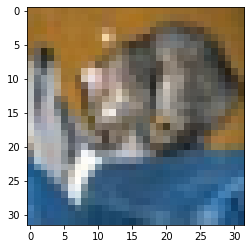

In [ ]:
plt.imshow(x_test[0])